In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import imageio
import numpy as np
import matplotlib
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm

# Define learning parameters

In [62]:
# learning parameters
batch_size = 512
epochs = 100
sample_size = 64 # fixed sample size for generator
nz = 128 # latent vector size
k = 1 # number of steps to apply to the discriminator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Prepare training dataset

In [3]:

transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])
to_pil_image = transforms.ToPILImage()

# Make input, output folders
!mkdir -p input
!mkdir -p outputs

# Load train data
train_data = datasets.MNIST(
    root='input/data',
    train=True,
    download=True,
    transform=transform
)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 109154116.00it/s]


Extracting input/data/MNIST/raw/train-images-idx3-ubyte.gz to input/data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 17653117.72it/s]


Extracting input/data/MNIST/raw/train-labels-idx1-ubyte.gz to input/data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 63888732.43it/s]

Extracting input/data/MNIST/raw/t10k-images-idx3-ubyte.gz to input/data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 17672104.61it/s]

Extracting input/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to input/data/MNIST/raw



# Generator

In [93]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

# Discriminator

In [94]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

In [95]:
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)
print('##### GENERATOR #####')
print(generator)
print('######################')
print('\n##### DISCRIMINATOR #####')
print(discriminator)
print('######################')

##### GENERATOR #####
Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
######################

##### DISCRIMINATOR #####
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1

# Tools for training

In [96]:
# optimizers
optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)

In [97]:
# loss function
criterion = nn.BCELoss() # Binary Cross Entropy loss

In [98]:
losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch
images = [] # to store images generatd by the generator

In [99]:
# to create real labels (1s)
def label_real(size):
    data = torch.ones(size, 1)
    return data.to(device)
# to create fake labels (0s)
def label_fake(size):
    data = torch.zeros(size, 1)
    return data.to(device)


In [100]:
# function to create the noise vector
def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz).to(device)

In [101]:
# to save the images generated by the generator
def save_generator_image(image, path):
    save_image(image, path)

In [102]:
# create the noise vector - fixed to track how GAN is trained.
noise = create_noise(sample_size, nz)

# Q. Write training loop

118it [00:18,  6.37it/s]                         


Epoch 1 of 100
Generator loss: 1.78392751, Discriminator loss: 0.89870858


118it [00:17,  6.82it/s]                         


Epoch 2 of 100
Generator loss: 1.78761760, Discriminator loss: 1.34066737


118it [00:17,  6.79it/s]                         


Epoch 3 of 100
Generator loss: 4.60108159, Discriminator loss: 0.95248250


118it [00:18,  6.54it/s]                         


Epoch 4 of 100
Generator loss: 5.66413027, Discriminator loss: 0.74246079


118it [00:17,  6.67it/s]                         


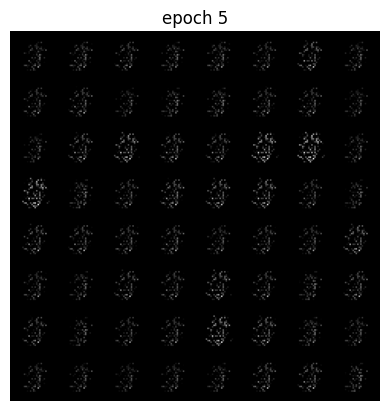

Epoch 5 of 100
Generator loss: 2.56891085, Discriminator loss: 1.09981398


118it [00:17,  6.57it/s]                         


Epoch 6 of 100
Generator loss: 1.65248327, Discriminator loss: 1.03452161


118it [00:17,  6.74it/s]                         


Epoch 7 of 100
Generator loss: 1.67693923, Discriminator loss: 1.08863796


118it [00:17,  6.60it/s]                         


Epoch 8 of 100
Generator loss: 1.72701239, Discriminator loss: 1.06429863


118it [00:17,  6.68it/s]                         


Epoch 9 of 100
Generator loss: 1.99121149, Discriminator loss: 1.04147771


118it [00:17,  6.75it/s]                         


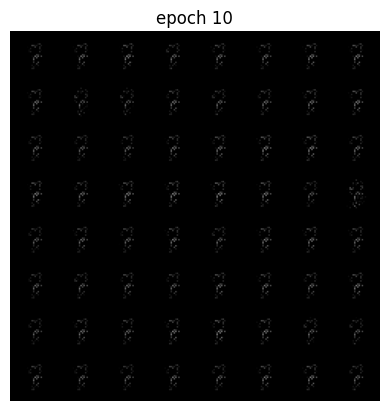

Epoch 10 of 100
Generator loss: 1.49105046, Discriminator loss: 1.13361010


118it [00:17,  6.59it/s]                         


Epoch 11 of 100
Generator loss: 2.39137115, Discriminator loss: 0.79118954


118it [00:17,  6.74it/s]                         


Epoch 12 of 100
Generator loss: 2.77261411, Discriminator loss: 0.70080362


118it [00:17,  6.60it/s]                         


Epoch 13 of 100
Generator loss: 2.87019490, Discriminator loss: 0.81808851


118it [00:17,  6.77it/s]                         


Epoch 14 of 100
Generator loss: 2.93760738, Discriminator loss: 0.78346682


118it [00:18,  6.55it/s]                         


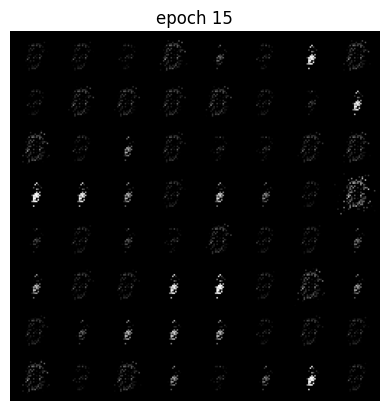

Epoch 15 of 100
Generator loss: 2.52079294, Discriminator loss: 0.86993204


118it [00:18,  6.41it/s]                         


Epoch 16 of 100
Generator loss: 2.84419565, Discriminator loss: 0.78308815


118it [00:18,  6.43it/s]                         


Epoch 17 of 100
Generator loss: 3.35706176, Discriminator loss: 0.66759981


118it [00:17,  6.61it/s]                         


Epoch 18 of 100
Generator loss: 3.56543891, Discriminator loss: 0.72887475


118it [00:17,  6.66it/s]                         


Epoch 19 of 100
Generator loss: 3.21715369, Discriminator loss: 0.79988926


118it [00:18,  6.50it/s]                         


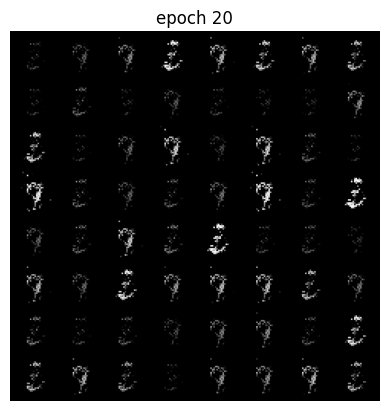

Epoch 20 of 100
Generator loss: 3.01740305, Discriminator loss: 0.71948057


118it [00:17,  6.72it/s]                         


Epoch 21 of 100
Generator loss: 3.34120906, Discriminator loss: 0.69149041


118it [00:18,  6.47it/s]                         


Epoch 22 of 100
Generator loss: 3.42532161, Discriminator loss: 0.68012366


118it [00:17,  6.71it/s]                         


Epoch 23 of 100
Generator loss: 3.34409716, Discriminator loss: 0.82936092


118it [00:18,  6.55it/s]                         


Epoch 24 of 100
Generator loss: 2.72985618, Discriminator loss: 0.76092144


118it [00:17,  6.65it/s]                         


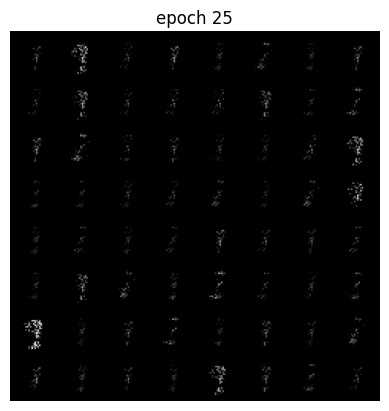

Epoch 25 of 100
Generator loss: 3.28869121, Discriminator loss: 0.66054619


118it [00:17,  6.67it/s]                         


Epoch 26 of 100
Generator loss: 3.20199398, Discriminator loss: 0.68162473


118it [00:18,  6.44it/s]                         


Epoch 27 of 100
Generator loss: 3.59955596, Discriminator loss: 0.64206459


118it [00:17,  6.61it/s]                         


Epoch 28 of 100
Generator loss: 3.41027679, Discriminator loss: 0.68170991


118it [00:18,  6.38it/s]                         


Epoch 29 of 100
Generator loss: 2.92231628, Discriminator loss: 0.75311467


118it [00:17,  6.59it/s]                         


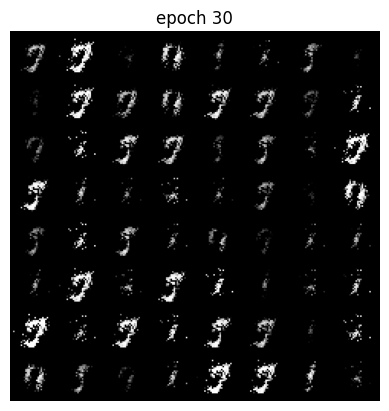

Epoch 30 of 100
Generator loss: 3.12674963, Discriminator loss: 0.72754449


118it [00:18,  6.47it/s]                         


Epoch 31 of 100
Generator loss: 3.22556149, Discriminator loss: 0.60596262


118it [00:17,  6.57it/s]                         


Epoch 32 of 100
Generator loss: 3.65319795, Discriminator loss: 0.62726464


118it [00:18,  6.44it/s]                         


Epoch 33 of 100
Generator loss: 3.59490803, Discriminator loss: 0.68111191


118it [00:18,  6.36it/s]                         


Epoch 34 of 100
Generator loss: 3.47027229, Discriminator loss: 0.65878105


118it [00:18,  6.48it/s]                         


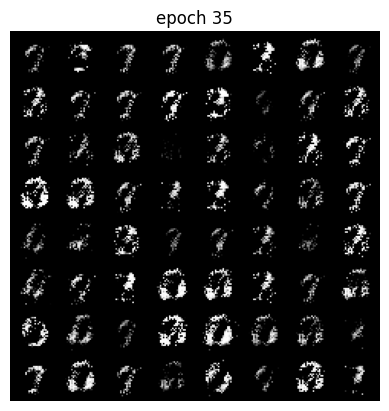

Epoch 35 of 100
Generator loss: 4.12380743, Discriminator loss: 0.61330499


118it [00:18,  6.40it/s]                         


Epoch 36 of 100
Generator loss: 3.64982645, Discriminator loss: 0.75908158


118it [00:18,  6.54it/s]                         


Epoch 37 of 100
Generator loss: 3.26884150, Discriminator loss: 0.75692401


118it [00:18,  6.25it/s]                         


Epoch 38 of 100
Generator loss: 3.11224582, Discriminator loss: 0.69612065


118it [00:18,  6.48it/s]                         


Epoch 39 of 100
Generator loss: 3.45457181, Discriminator loss: 0.65068069


118it [00:18,  6.27it/s]                         


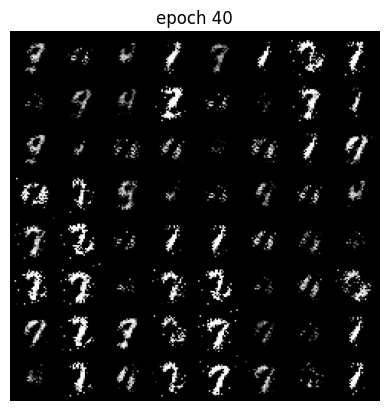

Epoch 40 of 100
Generator loss: 3.68711840, Discriminator loss: 0.69729325


118it [00:18,  6.44it/s]                         


Epoch 41 of 100
Generator loss: 3.77792279, Discriminator loss: 0.66409915


118it [00:18,  6.28it/s]                         


Epoch 42 of 100
Generator loss: 3.52874320, Discriminator loss: 0.68127185


118it [00:18,  6.47it/s]                         


Epoch 43 of 100
Generator loss: 3.34998196, Discriminator loss: 0.73226226


118it [00:18,  6.28it/s]                         


Epoch 44 of 100
Generator loss: 3.28380868, Discriminator loss: 0.71496823


118it [00:18,  6.50it/s]                         


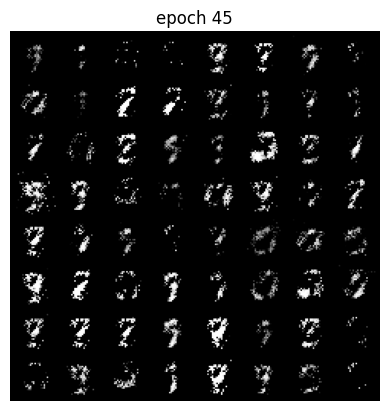

Epoch 45 of 100
Generator loss: 3.34645706, Discriminator loss: 0.69417167


118it [00:18,  6.21it/s]                         


Epoch 46 of 100
Generator loss: 3.42282957, Discriminator loss: 0.74341444


118it [00:18,  6.53it/s]                         


Epoch 47 of 100
Generator loss: 3.50800443, Discriminator loss: 0.68754141


118it [00:18,  6.38it/s]                         


Epoch 48 of 100
Generator loss: 3.03610817, Discriminator loss: 0.75796957


118it [00:18,  6.46it/s]                         


Epoch 49 of 100
Generator loss: 3.11707439, Discriminator loss: 0.70654857


118it [00:18,  6.46it/s]                         


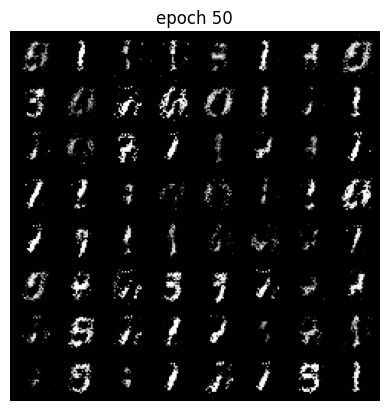

Epoch 50 of 100
Generator loss: 3.08551558, Discriminator loss: 0.74336782


118it [00:18,  6.27it/s]                         


Epoch 51 of 100
Generator loss: 3.04339730, Discriminator loss: 0.71824734


118it [00:18,  6.45it/s]                         


Epoch 52 of 100
Generator loss: 2.96268433, Discriminator loss: 0.70478045


118it [00:18,  6.24it/s]                         


Epoch 53 of 100
Generator loss: 3.15479054, Discriminator loss: 0.71246380


118it [00:18,  6.47it/s]                         


Epoch 54 of 100
Generator loss: 3.03703533, Discriminator loss: 0.72228755


118it [00:19,  6.19it/s]                         


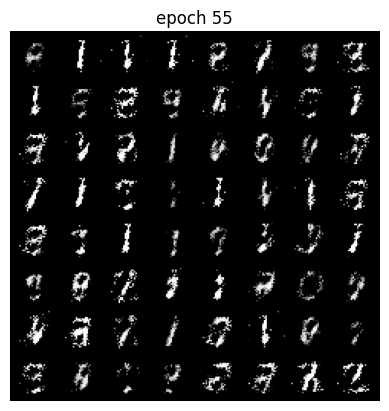

Epoch 55 of 100
Generator loss: 2.87611553, Discriminator loss: 0.77820783


118it [00:18,  6.55it/s]                         


Epoch 56 of 100
Generator loss: 2.89680803, Discriminator loss: 0.77639870


118it [00:18,  6.32it/s]                         


Epoch 57 of 100
Generator loss: 2.87513281, Discriminator loss: 0.81567689


118it [00:18,  6.52it/s]                         


Epoch 58 of 100
Generator loss: 2.62556111, Discriminator loss: 0.83315142


118it [00:18,  6.25it/s]                         


Epoch 59 of 100
Generator loss: 2.79972116, Discriminator loss: 0.76772374


118it [00:18,  6.52it/s]                         


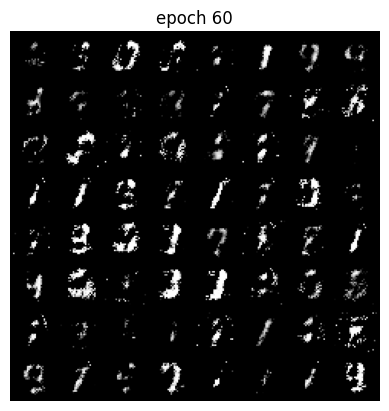

Epoch 60 of 100
Generator loss: 2.67612716, Discriminator loss: 0.77422493


118it [00:18,  6.28it/s]                         


Epoch 61 of 100
Generator loss: 2.80510183, Discriminator loss: 0.77453311


118it [00:18,  6.38it/s]                         


Epoch 62 of 100
Generator loss: 2.68666865, Discriminator loss: 0.79190984


118it [00:18,  6.43it/s]                         


Epoch 63 of 100
Generator loss: 2.61313848, Discriminator loss: 0.80962504


118it [00:18,  6.39it/s]                         


Epoch 64 of 100
Generator loss: 2.55018642, Discriminator loss: 0.82244499


118it [00:18,  6.49it/s]                         


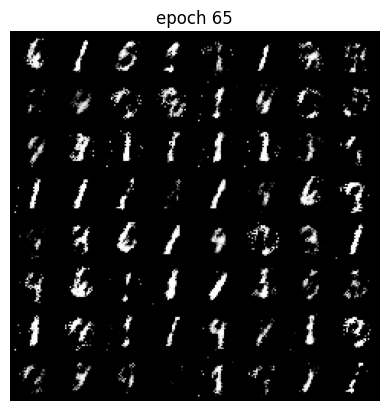

Epoch 65 of 100
Generator loss: 2.55699673, Discriminator loss: 0.83305205


118it [00:18,  6.24it/s]                         


Epoch 66 of 100
Generator loss: 2.53951799, Discriminator loss: 0.82913623


118it [00:18,  6.48it/s]                         


Epoch 67 of 100
Generator loss: 2.46532399, Discriminator loss: 0.85153530


118it [00:19,  6.17it/s]                         


Epoch 68 of 100
Generator loss: 2.28873402, Discriminator loss: 0.85397182


118it [00:18,  6.55it/s]                         


Epoch 69 of 100
Generator loss: 2.21982888, Discriminator loss: 0.86465399


118it [00:18,  6.24it/s]                         


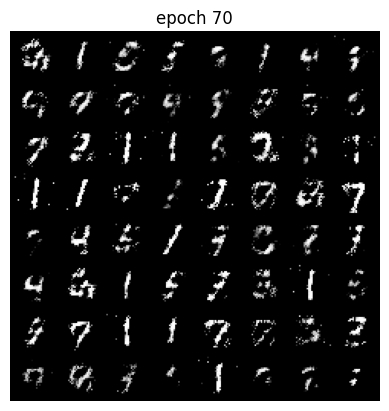

Epoch 70 of 100
Generator loss: 2.38858970, Discriminator loss: 0.83557471


118it [00:18,  6.47it/s]                         


Epoch 71 of 100
Generator loss: 2.33746002, Discriminator loss: 0.87476221


118it [00:18,  6.29it/s]                         


Epoch 72 of 100
Generator loss: 2.32083754, Discriminator loss: 0.86233748


118it [00:18,  6.54it/s]                         


Epoch 73 of 100
Generator loss: 2.35251787, Discriminator loss: 0.88492923


118it [00:18,  6.36it/s]                         


Epoch 74 of 100
Generator loss: 2.47333943, Discriminator loss: 0.84854109


118it [00:17,  6.56it/s]                         


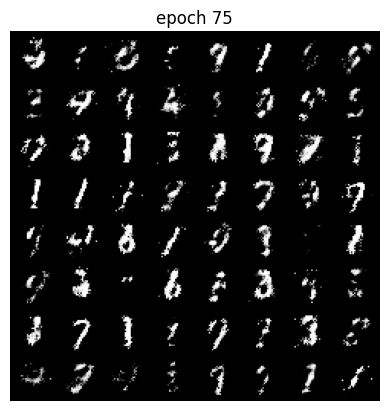

Epoch 75 of 100
Generator loss: 2.27775354, Discriminator loss: 0.88381793


118it [00:18,  6.52it/s]                         


Epoch 76 of 100
Generator loss: 2.45183839, Discriminator loss: 0.81268244


118it [00:18,  6.45it/s]                         


Epoch 77 of 100
Generator loss: 2.47778707, Discriminator loss: 0.81565727


118it [00:17,  6.63it/s]                         


Epoch 78 of 100
Generator loss: 2.38447745, Discriminator loss: 0.85544081


118it [00:18,  6.31it/s]                         


Epoch 79 of 100
Generator loss: 2.42155727, Discriminator loss: 0.86503384


118it [00:17,  6.68it/s]                         


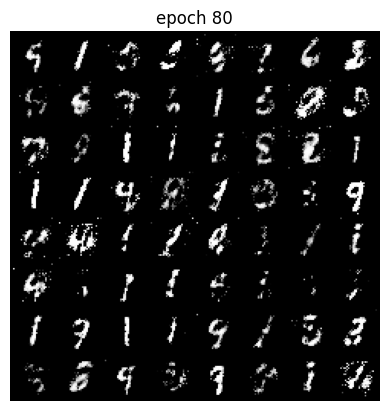

Epoch 80 of 100
Generator loss: 2.36747448, Discriminator loss: 0.87152642


118it [00:19,  6.17it/s]                         


Epoch 81 of 100
Generator loss: 2.18565554, Discriminator loss: 0.88053756


118it [00:18,  6.55it/s]                         


Epoch 82 of 100
Generator loss: 2.31001575, Discriminator loss: 0.87679283


118it [00:18,  6.35it/s]                         


Epoch 83 of 100
Generator loss: 2.12665570, Discriminator loss: 0.90230644


118it [00:18,  6.54it/s]                         


Epoch 84 of 100
Generator loss: 2.13759445, Discriminator loss: 0.89885748


118it [00:18,  6.48it/s]                         


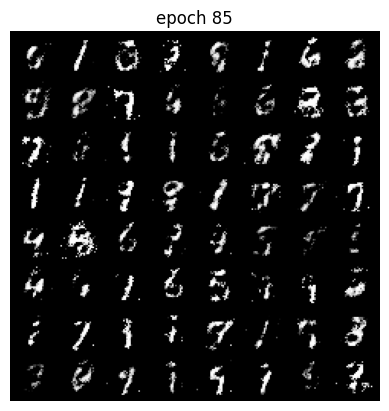

Epoch 85 of 100
Generator loss: 2.20871556, Discriminator loss: 0.89302266


118it [00:18,  6.36it/s]                         


Epoch 86 of 100
Generator loss: 2.01012082, Discriminator loss: 0.94682677


118it [00:17,  6.57it/s]                         


Epoch 87 of 100
Generator loss: 2.02088641, Discriminator loss: 0.94727812


118it [00:18,  6.32it/s]                         


Epoch 88 of 100
Generator loss: 2.25185931, Discriminator loss: 0.87654529


118it [00:17,  6.61it/s]                         


Epoch 89 of 100
Generator loss: 2.08569051, Discriminator loss: 0.92548592


118it [00:18,  6.40it/s]                         


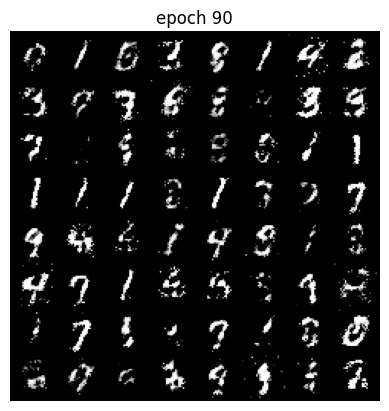

Epoch 90 of 100
Generator loss: 2.16440758, Discriminator loss: 0.89901726


118it [00:17,  6.61it/s]                         


Epoch 91 of 100
Generator loss: 1.94874694, Discriminator loss: 0.93956384


118it [00:18,  6.41it/s]                         


Epoch 92 of 100
Generator loss: 2.01177308, Discriminator loss: 0.93950814


118it [00:17,  6.60it/s]                         


Epoch 93 of 100
Generator loss: 2.09801004, Discriminator loss: 0.92539842


118it [00:18,  6.37it/s]                         


Epoch 94 of 100
Generator loss: 2.21422967, Discriminator loss: 0.87505484


118it [00:18,  6.26it/s]                         


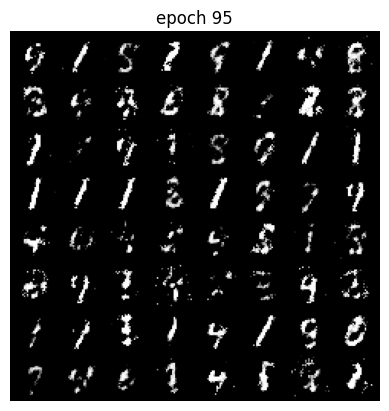

Epoch 95 of 100
Generator loss: 2.06053859, Discriminator loss: 0.93337219


118it [00:17,  6.64it/s]                         


Epoch 96 of 100
Generator loss: 2.08710345, Discriminator loss: 0.92152556


118it [00:19,  6.21it/s]                         


Epoch 97 of 100
Generator loss: 2.01519983, Discriminator loss: 0.93270146


118it [00:18,  6.49it/s]                         


Epoch 98 of 100
Generator loss: 2.03791412, Discriminator loss: 0.92833134


118it [00:19,  6.20it/s]                         


Epoch 99 of 100
Generator loss: 2.03346309, Discriminator loss: 0.94694017


118it [00:18,  6.52it/s]                         


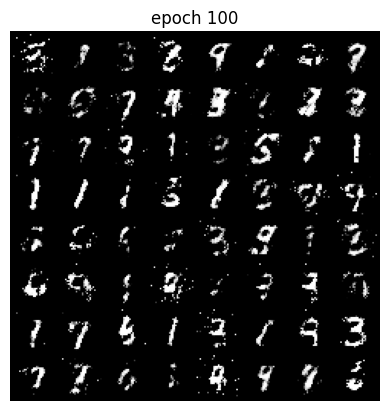

Epoch 100 of 100
Generator loss: 1.95086289, Discriminator loss: 0.94323648


In [103]:
torch.manual_seed(7777)

def generator_loss(output, true_label):
    ############ YOUR CODE HERE ##########

    loss = criterion(output, true_label)

    return loss
    
    ######################################
    
def discriminator_loss(output, true_label):
    ############ YOUR CODE HERE ##########


    loss = criterion(output, true_label)
    
    return loss
    ######################################
    

for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        ############ YOUR CODE HERE ########## 
        image, _ = data
        image = image.to(device)
        b_size = len(image)
        # run the discriminator for k number of steps
        for step in range(k):
            data_fake = generator(create_noise(b_size, nz)).detach()
            data_real = image
            # train the discriminator network
            b_size = data_real.size(0)
            # Q1
            # real_label = label_real(b_size)
            # Q3
            real_label = label_real(b_size) * 0.9
            fake_label = label_fake(b_size)
            optim_d.zero_grad()
            output_real = discriminator(data_real)
            output_fake = discriminator(data_fake)
            loss_real = discriminator_loss(output_real, real_label)
            loss_fake = discriminator_loss(output_fake, fake_label)
            d_loss = loss_real + loss_fake
            d_loss.backward()
            # loss_real.backward()
            # loss_fake.backward()
            optim_d.step()
            loss_d += d_loss.item()

        data_fake = generator(create_noise(b_size, nz))
        # train the generator network
        b_size = data_fake.size(0)
        # Q1
        # real_label = label_real(b_size)
        # Q3
        real_label = label_real(b_size) * 0.9
        fake_label = label_fake(b_size)
        optim_g.zero_grad()
        output = discriminator(data_fake)
        # Q2
        # g_loss = generator_loss(output, fake_label)
        # Q1 Q3
        g_loss = generator_loss(output, real_label)
        g_loss.backward()
        optim_g.step()
        loss_g += g_loss.item()
    
        ######################################
    
    
    # create the final fake image for the epoch
    generated_img = generator(noise).cpu().detach()
    
    # make the images as grid
    generated_img = make_grid(generated_img)
    
    # visualize generated images
    if (epoch + 1) % 5 == 0:
        plt.imshow(generated_img.permute(1, 2, 0))
        plt.title(f'epoch {epoch+1}')
        plt.axis('off')
        plt.show()
    
    # save the generated torch tensor models to disk
    save_generator_image(generated_img, f"outputs/gen_img{epoch+1}.png")
    images.append(generated_img)
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)
    
    print(f"Epoch {epoch+1} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

In [104]:
print('DONE TRAINING')
torch.save(generator.state_dict(), 'outputs/generator.pth')

DONE TRAINING


In [105]:
# save the generated images as GIF file
imgs = [np.array(to_pil_image(img)) for img in images]
imageio.mimsave('outputs/generator_images.gif', imgs)

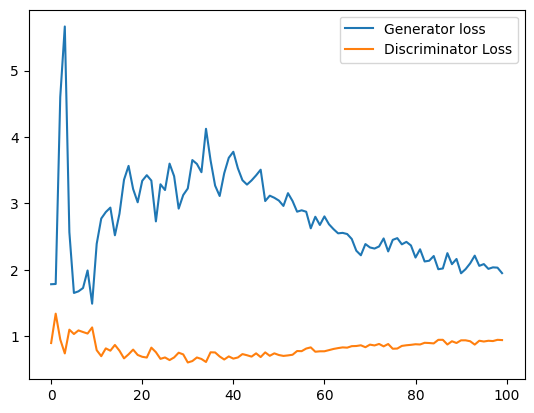

In [106]:
# plot and save the generator and discriminator loss
plt.figure()
plt.plot(losses_g, label='Generator loss')
plt.plot(losses_d, label='Discriminator Loss')
# plt.plot(losses_g_cpu, label='Generator loss')
# plt.plot(losses_d_cpu, label='Discriminator Loss')
plt.legend()
plt.savefig('outputs/loss.png')